# BGC-Argo data pipline

In [8]:
# Standard library imports
import glob
import warnings

# Third-party imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import copernicus_marine_client as copernicus_marine
import geopandas as gp
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy import stats

# Local application/library specific imports
from argo_download import *
from filter_outliers import *
from get_regions import *
from hbt_assign import *
from hbt_def_var import *
from pft import *

# Configure warnings
warnings.filterwarnings("ignore")


## Download data
The first step is to retrieve the BGC-Argo floats from GDAC server under netCDF (.nc) format

In [9]:
# # Download files
# wmoids, gdac_index, downloaded_filenames = argo_gdac(lon_range=[-70, -10], # -70, 12
#                                                      lat_range=[0, 23.5], # 0, 23.5
#                                                      sensors=['CHLA','NITRATE'],
#                                                      #start_date=datetime(2020,1,1),
#                                                      overwrite_profiles=True,
#                                                      overwrite_index=True,
#                                                      skip_download=False,
#                                                     save_to='Downloads')
# # '''
# # Downloads GDAC Sprof index file, then selects float profiles based on criteria.
# # Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).
# # Arguments:
# #     url_root: GDAC servers. Available servers include:
# #                 'ftp://usgodae.org/pub/outgoing/argo/'
# #                 'https://data-argo.ifremer.fr/' 
# #                 'ftp://ftp.ifremer.fr/ifremer/argo' 
# #     lat_range: None, to select all latitudes
# #                 or [lower, upper] within -90 to 90 (selection is inclusive)
# #     lon_range: None, to select all longitudes
# #                 or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
# #                 NOTE: longitude range is allowed to cross -180/180 or 0/360
# #     start_date: None or datetime object
# #     end_date:   None or datetime object
# #     sensors: None, to select profiles with any combination of sensors
# #             or string or list of strings to specify required sensors
# #             > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
# #                                                 PH_IN_SITU_TOTAL, and NITRATE
# #     floats: None, to select any floats matching other criteria
# #             or int or list of ints specifying floats' WMOID numbers
# #     overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
# #     overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
# #     skip_download: True to skip download and return: (<list of WMOIDs>, <DataFrame of index file subset>,
# #                                                     <list of downloaded filenames [if applicable]>)
# #                     or False to download those profiles
# #     download_individual_profs: False to download single Sprof file containing all profiles for each float
# #                                 or True to download individual profile files for each float
# #     save_to: None to download to <cwd>/Downloads or string to specify directory path for profile downloads
# #     verbose: True to announce progress, or False to stay silent
# # '''

## Compute Habitat defining variables
This step scans through all downloaded .nc files and produce a .csv table for each file containing the metadata and the caculated habitat-defining variable and biological estimations, then merge all .csv file into one large dataset.

In [10]:
# # # Get list of file name in directory if 1st cell not run
# file_paths = glob.glob(f'Downloads/*_Sprof.nc')
# downloaded_filenames = [os.path.basename(file_path) for file_path in file_paths]
# downloaded_filenames = list(set(downloaded_filenames)-set(['1902383_Sprof.nc','3902122_Sprof.nc','3902123_Sprof.nc'])) # Remove these files as they are mostly errors
# # Create folder for csv output
# save_dir = 'Hbt_def_var'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# # Wraper function for parallelization, 
# def wraper_func(files):
#     model_run(files,file_dir='Downloads',save_dir=save_dir,NAI_boundary=1,N2_local_max=0,d_theta=0.3)

#     '''
#     Function to calculate habitat defining variable of a single float cycle from BGC-ARGO
#     Input:
#     - mydata: input BGC-ARGO data download by argo_download.py
#     - data_mode: list of data mode to be included in calculation. 'D': delayed mode, 'A': adjusted real time mode, 'R': real time mode
#     - flag: list of quality control flag to be included in calculation. Remove 3 & 4 by default for 'bad' and 'potentially bad' data.
#     - var_adj: whether adjusted data should be used
#     - depth_top: end code if minimum profile depth higher than depth_top
#     - depth_bottom: end code if maximum profile depth lower than depth_bottom 
#     - N2_local_max: n-th local maximum from surface, set to FALSE or 0 for global maximum
#     - d_sigma: density difference to define mixed layer depth
#     - d_theta: temperature difference to define mixed layer depth
#     - smooth: set to True to apply smoothing using rolling_average function
#     - smooth_window: depth interval used in rolling_average function
#     - by_mean: set to True for using rolling mean, False for rolling median
#     - peak_height: peak filtering criteria for signal processing
#     - CHLA_threshold: criteria for defining depth of constant chlorophyll
#     - dNITRATE_ref: criteria for defining depth of the nitracline
#     - NAI_boundary: suface boundary for NAI calculation, default is 0.5 uM as in Weber et al. 2019
#     - plot: option to plot water column profiles, default is FALSE
#     - plot_extra: option to plot advance profile
#     - zmax: depth limit for plotting, default is 500m
#     - verbose: show more information
#     '''

# # Run for hdv calculation
# parallelize_hbt(wraper_func,downloaded_filenames)

In [11]:
# # Run time test
# import time
# time_avg = []
# for sf in floatlist:
#     test = xr.open_dataset(f"Downloads/{sf}_Sprof.nc")
#     test['N_PROF'] = test.N_PROF
#     total = 0
#     for i in np.unique(test.N_PROF):
#         start = time.time()
#         def_var(test.isel(N_PROF=i))
#         end = time.time()
#         total += end - start
#     time_avg.append(total/np.size(np.unique(test.N_PROF)))
# np.mean(time_avg)

In [12]:
# # Stack all csv file
# folder = 'Hbt_def_var' # calculated file directory
# data_all =  pd.DataFrame() # create empty list
# mylist = []
# for f in glob.glob(f"{folder}/*_hdv.csv"):
#     df = pd.read_csv(f) 
#     mylist.append(df)

# data_all = pd.concat(mylist).reset_index(drop=True)
# data_all['Date'] = pd.to_datetime(data_all.Date)
# data_all['DOY'] = data_all.Date.dt.dayofyear

# # Export
# data_all.to_csv("data_hdv.csv",index=False)

In [13]:
data_all = pd.read_csv('data_hdv.csv')
# Map
data_all['Float'] = data_all['Float'].astype('category')
k = np.size(np.unique(data_all.Float))
mycolor = generate_distinct_colors(k,'gist_rainbow')
color_dict = {i : color for i, color in zip(data_all['Float'].cat.categories,mycolor)}
plt.figure(figsize=(15,15))
fig = px.scatter_geo(data_all, lon='Lon',lat='Lat', hover_name='Float',color='Float',
                     hover_data=['Date','SST','SSS','MLD','DCM','DNC','NAI'],
                     color_discrete_map=color_dict,projection='natural earth')

# tight layout
fig.update_traces(marker=dict(size=10,line = dict(width=1,color='black'),),opacity=1)
fig.update_xaxes(range=[-180, 180])
fig.update_yaxes(range=[-90, 90])
dtick = 30
fig.update_layout(geo=dict(showland=True,
                           lonaxis=dict(showgrid=True, dtick=dtick, gridcolor='black', gridwidth=0.5),
                           lataxis=dict(showgrid=True, dtick=dtick, gridcolor='black', gridwidth=0.5)))

print('Total number of floats {}'.format(np.size(np.unique(data_all.Float))))
print('Total number of unique cycles {}'.format(np.size(data_all.Float_cycle)))
fig.show(render='notebook')

Total number of floats 19
Total number of unique cycles 1592


<Figure size 1500x1500 with 0 Axes>

## Regions masking
This step is optional, where I assigned each float profile into it corresponding Ocean Region and Longhurst's provinces

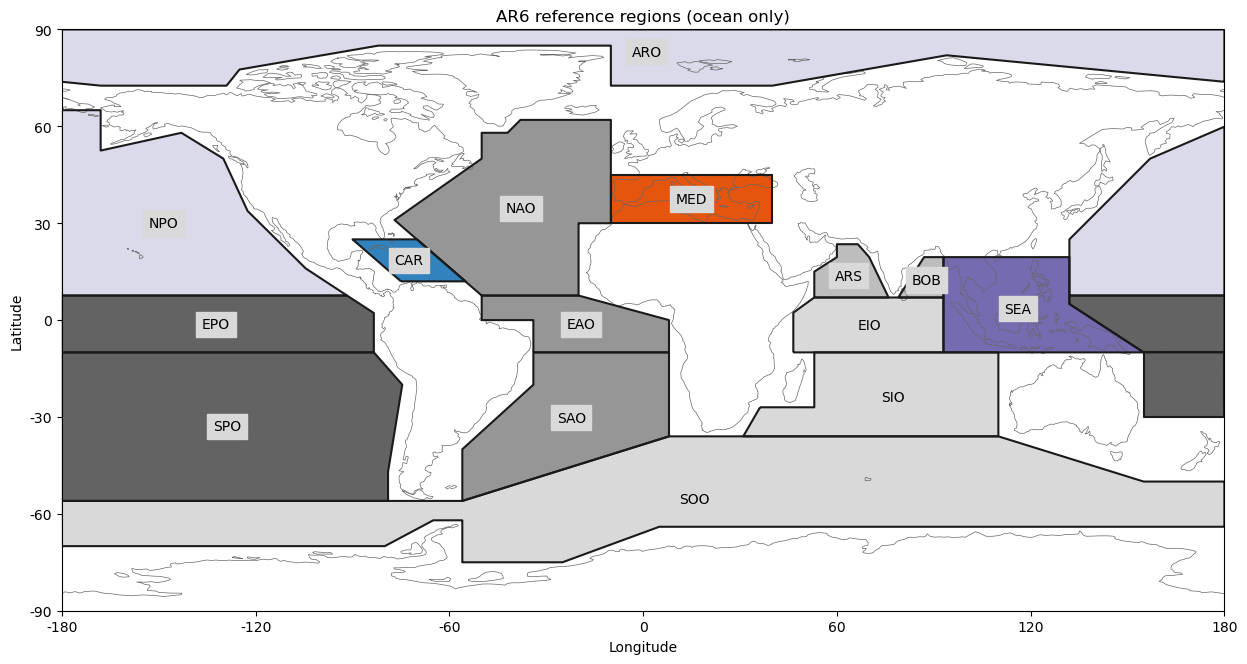

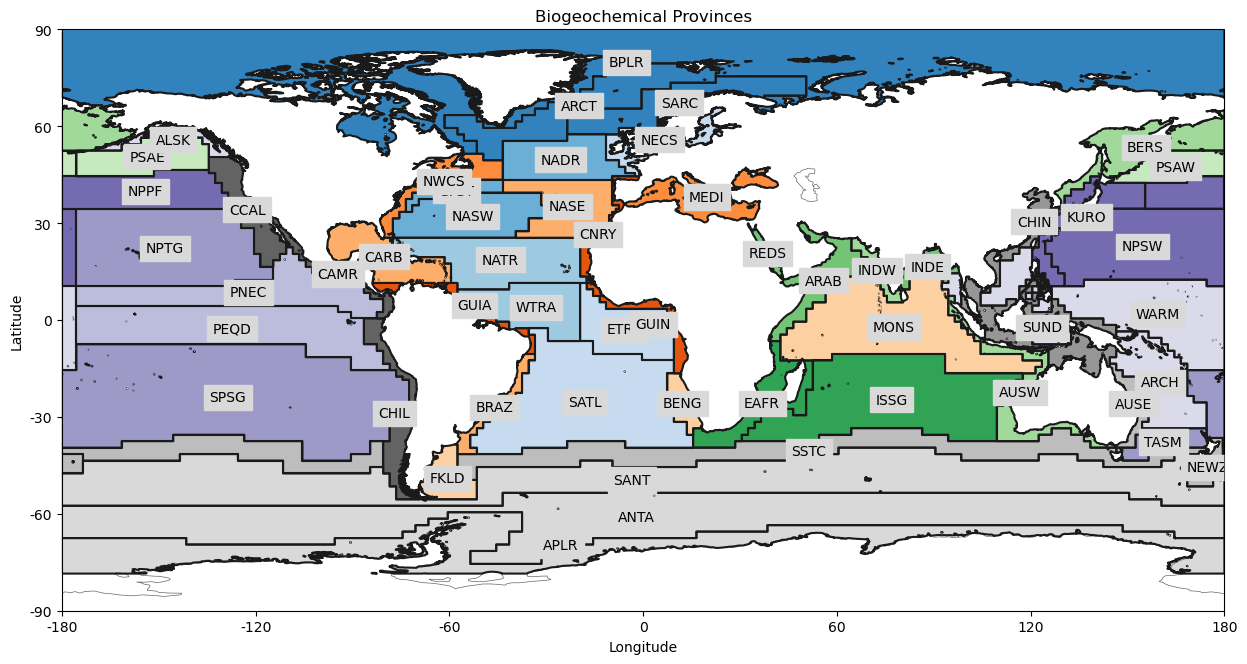

In [14]:
# Apply region mask to BGC-Argo Dataset
import geopandas as gp
import regionmask
# AR6 Ocean regions
region_ids, region_mask, region_code = set_up_mask(regionmask.defined_regions.ar6.ocean)
data_all['RegionID'], data_all['Region'], data_all['RegionFull'] = get_regions(data_all.Lon,
                                                                               data_all.Lat,
                                                                               region_mask=region_mask,
                                                                               region_code=region_code)

# Longhurst Provinces from shapefile
file = gp.read_file('longhurst_v4_2010/')
lhprovinces = regionmask.from_geopandas(file, names="ProvDescr", abbrevs="ProvCode", name="Biogeochemical Provinces")
lh_ids, lh_mask, lh_code = set_up_mask(lhprovinces)
data_all['ProvinceID'], data_all['Province'], data_all['ProvinceFull'] = get_regions(data_all.Lon,
                                                                                     data_all.Lat,
                                                                                     region_mask=lh_mask,
                                                                                     region_code=lh_code)

## Data cleaning
This step will remove any float cycle that doesn't have all five valid measurement of the habitat-defining variables

Total number of floats 16
Total number of unique cycles 1155


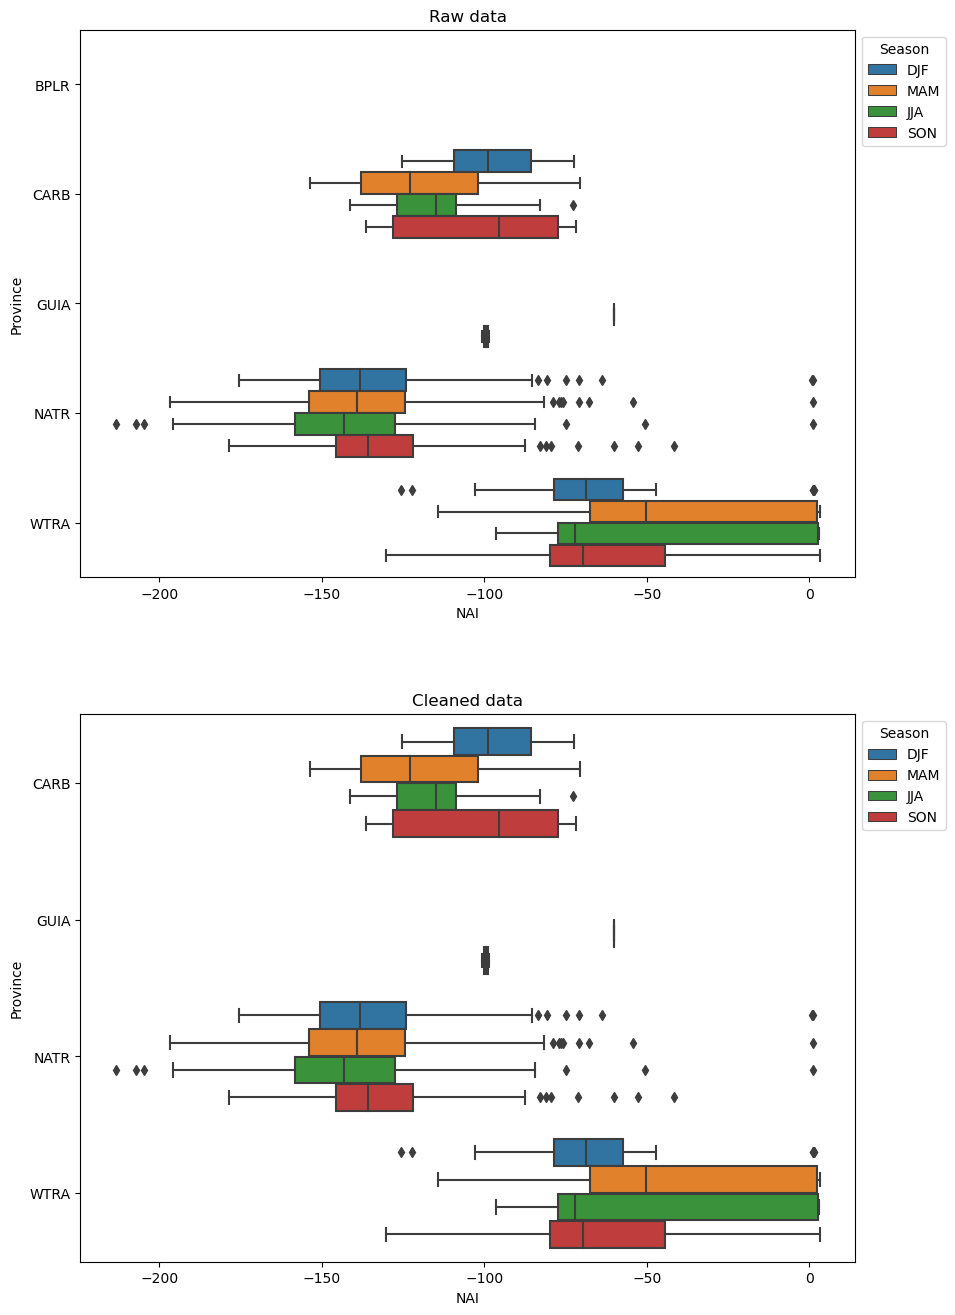

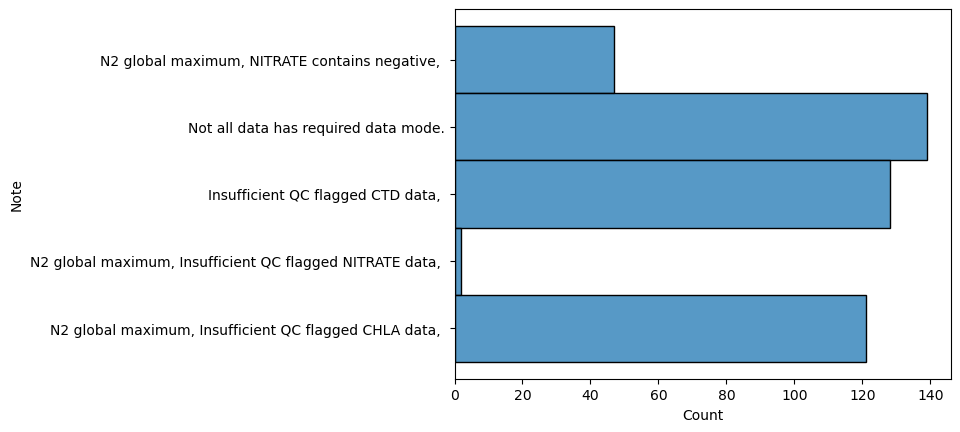

In [15]:
import seaborn as sns
# Init setup
data_all['Province']=data_all['Province'].astype('category')
data_all['Date'] = pd.to_datetime(data_all.Date)
data_all['DOY'] = data_all.Date.dt.dayofyear
var_list=['MLD_2','DCM','SST','SSS','NAI']

# Data cleaning
data_clean = data_all.dropna(subset=var_list) # remove row that contain NAs in variables
#data_clean = filter_outliers_n(data_clean, ['Province','Season'],var_list,lower_quantile=0.25,upper_quantile=0.75) # filter by groups based on quantile range
data_clean['Province'] = data_clean['Province'].cat.remove_unused_categories() # Remove categories with no data
data_clean = data_clean.reset_index(drop=True)
print('Total number of floats {}'.format(np.size(np.unique(data_clean.Float))))
print('Total number of unique cycles {}'.format(np.size(data_clean.Float_cycle)))

# Plotting
x = 'NAI' # Variables to plot
y = 'Province' # Regions to plot
sns.set_style(style='white')
sns.set(font_scale=2)

plt.style.use('default')

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10, 16))
# Box plot
sns.boxplot(data_all,x=x,y=y,hue='Season',palette='tab10',ax=ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax1.set_title('Raw data')

# Distribution plot
sns.boxplot(data_clean,x=x,y=y,hue='Season',palette='tab10',ax=ax2)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
ax2.set_title('Cleaned data')

fig.subplots_adjust(hspace=0.25)
plt.show()

# Error check
# error = invalid.Note.value_counts()
# error
invalid = data_all[np.isnan(data_all[var_list]).any(axis=1)]
sns.histplot(y=invalid.Note)
plt.show()

## Habitat assignments
This is the main step of the pipeline, where each float cycle is categorized into habitat types via hierarchical clustering

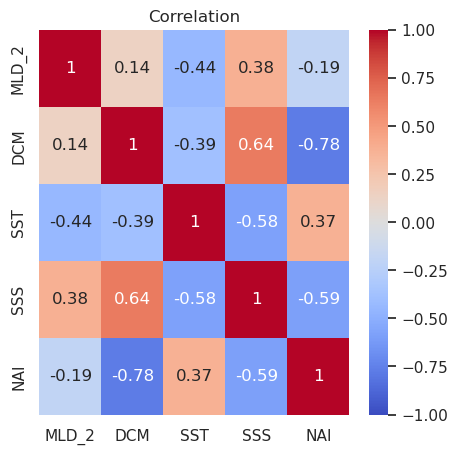

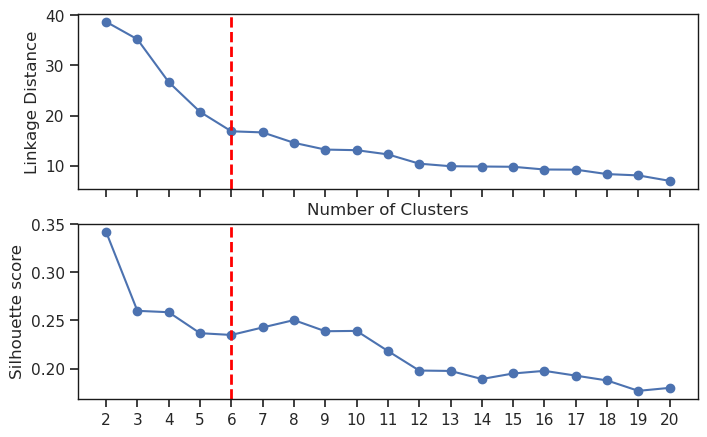

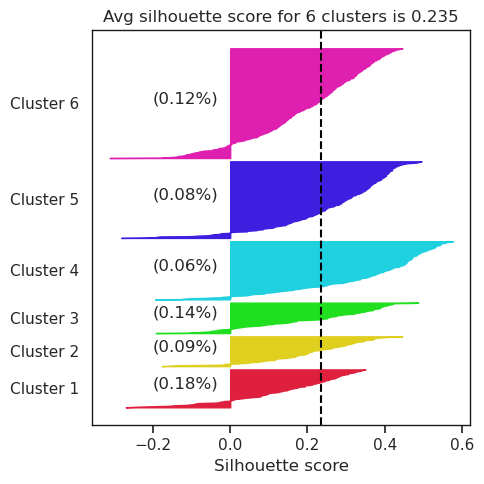

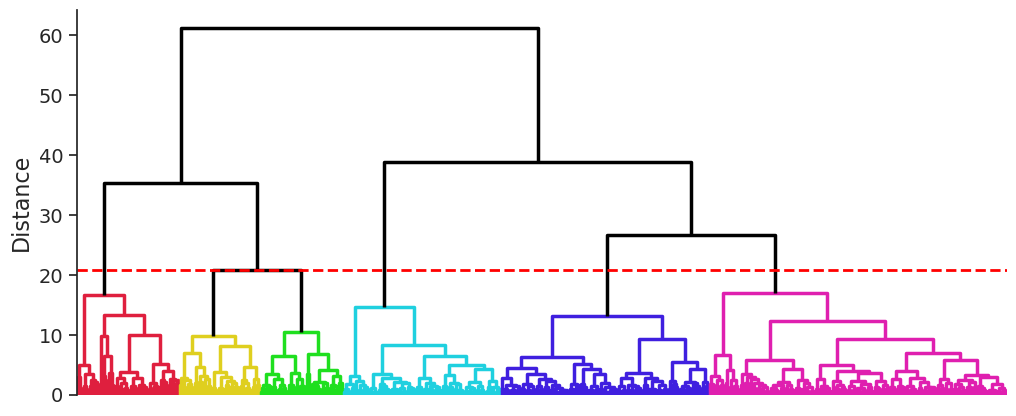

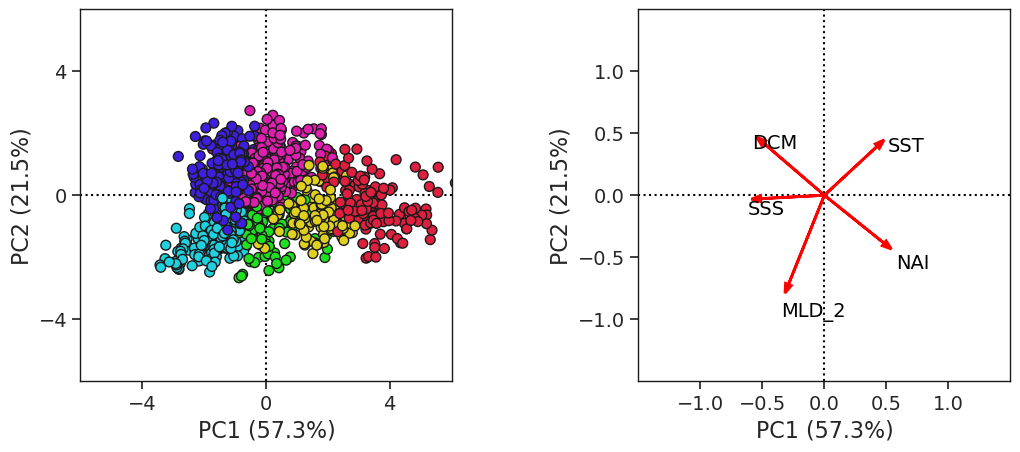

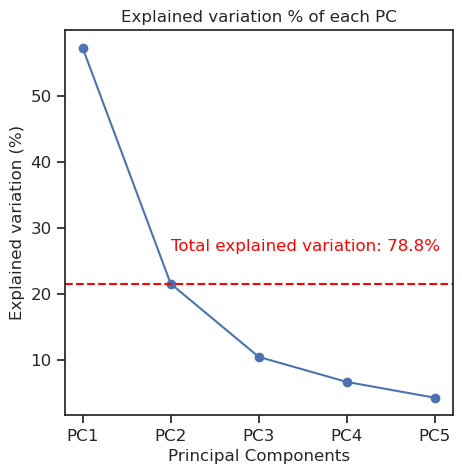

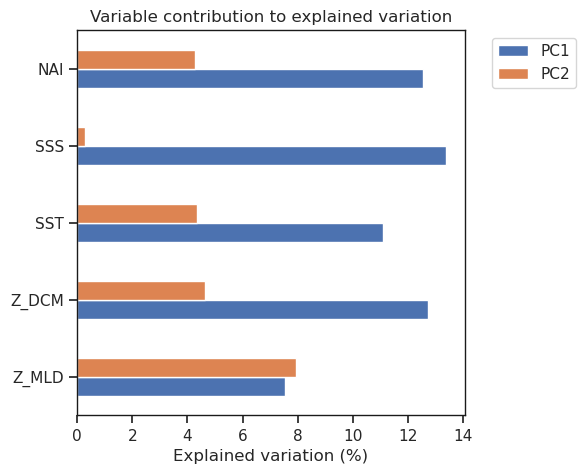

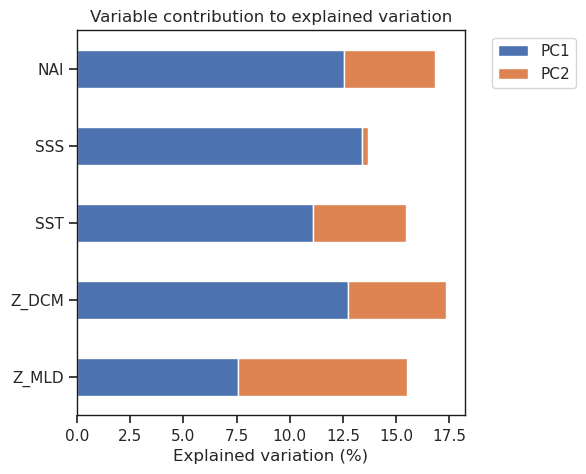

In [21]:
# Habitat assignment
seed=25
random.seed(seed)
sns.set(font_scale=1)
sns.set_style(style='white')
df = data_clean[var_list] # Extract habitat-defining variables data
df = (df - df.mean()) / df.std() # Scale data
k=6 # number of cluster

# Create color plallete base on number of cluster
mycolor = generate_distinct_colors(k,'gist_rainbow',saturation=0.75,lightness=0.5,random=False)

# Correlation analysis
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(df.corr().round(2), annot=True, cmap="coolwarm",vmin=-1,vmax=1)
plt.title("Correlation")

# Compute linkage matrix
linkage_matrix = linkage(df, method='ward', metric='euclidean',optimal_ordering=False)
#linkage_matrix = optimal_leaf_ordering(linkage_matrix, df)

# Hiearchical clustering
hclust_crit(df,linkage_matrix, k, kmax=20, figsize=(8,5)) # clustering criteria
sscore = hca_silhouette_score(df,linkage_matrix,k,mycolor,figsize=(5,5))
cluster = hclust(linkage_matrix, k=k, mycolor=mycolor, labels=data_clean.Float_cycle.values,show_label=False) # Return dendrogram and cluster labels


# Principal component analysis
npc = 2
pca(df, npc, var_list=var_list, cluster=cluster, mycolor=mycolor, lim=6, tick_spacing=4,pc2=2, show_label=True,s=50) # Return biplot
pca_var_explain(df, npc, figsize=(5,5))
pca_var_contr(df, npc, var_list=['Z_MLD','Z_DCM','SST','SSS','NAI'], explained_ratio=True,figsize=(5,5)) # Plot contribution of each variables to each PCs
pca_var_contr(df, npc, var_list=['Z_MLD','Z_DCM','SST','SSS','NAI'], explained_ratio=True,stacked=True,figsize=(5,5)) # Plot contribution of each variables to each PCs

# Save to table
data_clean['Cluster'] = pd.Categorical(cluster)
data_clean['Silhouette'] = sscore
# Export
#data_clean.to_csv("data_clean_clustered.csv",index=False)

In [22]:
# Spatial distribution
def map_plot(data,mycolor):
    color_dict = dict(zip(data['Cluster'].cat.categories,mycolor))
    plt.figure(figsize=(15,15))
    fig = px.scatter_geo(data, lon='Lon',lat='Lat', hover_name='Float_cycle',color='Cluster',
                         hover_data=['N_PROF','RegionFull','ProvinceFull','Date','SST','SSS','MLD','DCM','DNC','NAI'],
                         color_discrete_map=color_dict,projection='natural earth')

    # tight layout
    fig.update_traces(marker=dict(size=10,line = dict(width=1,color='black')),opacity=1)
    fig.update_xaxes(range=[-180, 180])
    fig.update_yaxes(range=[-90, 90])
    dtick = 30
    fig.update_layout(geo=dict(showland=True,
                               lonaxis=dict(showgrid=True, dtick=dtick, gridcolor='black', gridwidth=0.5),
                               lataxis=dict(showgrid=True, dtick=dtick, gridcolor='black', gridwidth=0.5)))
    fig.show()
map_plot(data_clean,mycolor=mycolor)

<Figure size 1500x1500 with 0 Axes>

In [18]:
# Compute float sampling resolution
# Get list of all downloaded floats
file_paths = glob.glob(f'Downloads/*_Sprof.nc')
downloaded_filenames = [os.path.basename(file_path) for file_path in file_paths]
downloaded_filenames = list(set(downloaded_filenames)-set(['1902383_Sprof.nc','3902122_Sprof.nc','3902123_Sprof.nc'])) # Remove these files as they are mostly errors

# Get median resolution
res = {}
for f in downloaded_filenames:
    test = xr.open_dataset(f"Downloads/{f}")
    res[f.strip('_Sprof.nc')] = np.nanmedian(np.diff(test.PRES)).round(2)
res = dict(sorted(res.items()))
res

{'1902380': 2.0,
 '1902381': 2.0,
 '1902382': 2.0,
 '1902384': 2.0,
 '3901578': 0.8,
 '3902498': 0.9,
 '4903458': 2.0,
 '4903459': 2.0,
 '4903462': 2.0,
 '4903463': 2.0,
 '4903486': 2.0,
 '5906339': 2.0,
 '5906343': 2.0,
 '5906434': 2.0,
 '5906436': 2.0,
 '5906437': 2.0,
 '6901472': 0.6,
 '6901474': 0.6,
 '6904189': 0.8}

In [37]:
# Compute float sampling resolution
# Get list of all downloaded floats
file_paths = glob.glob(f'Downloads/*_Sprof.nc')
downloaded_filenames = [os.path.basename(file_path) for file_path in file_paths]
downloaded_filenames = list(set(downloaded_filenames)-set(['1902383_Sprof.nc','3902122_Sprof.nc','3902123_Sprof.nc'])) # Remove these files as they are mostly errors

# Get median resolution
res = {}
for f in downloaded_filenames:
    test = xr.open_dataset(f"Downloads/{f}")
    res[f.strip('_Sprof.nc')] = np.nanmin(test.PRES_ADJUSTED).round(2)
res = dict(sorted(res.items()))
res

{'1902380': 1.14,
 '1902381': 0.35,
 '1902382': 1.83,
 '1902384': 1.94,
 '3901578': nan,
 '3902498': -0.21,
 '4903458': 1.99,
 '4903459': 2.26,
 '4903462': 2.14,
 '4903463': 2.11,
 '4903486': 2.09,
 '5906339': 4.05,
 '5906343': 2.54,
 '5906434': 1.98,
 '5906436': 2.09,
 '5906437': 2.87,
 '6901472': -0.25,
 '6901474': -0.18,
 '6904189': nan}

,Float,N_PROF,Cycle,Float_Cycle,Date,Year,Month,Hour,Season,Daynight,...,CHL_profile,BBP_ratio,KPAR,MLD_2,MLD_3,DNC_2,NAI_2,Data_mode,QC,Note
0,5906434,9,10,5906434_10,07/09/2021 08:24:23,2021,7,8,JJA,Day,...,DAM,1.093854,0.043626,18.442929,81.585897,76.228035,-76.228035,"'D', 'A'","1, 2, 3, 4, 5, 6, 7, 8","N2 global maximum, dNITRATE global maximum,"


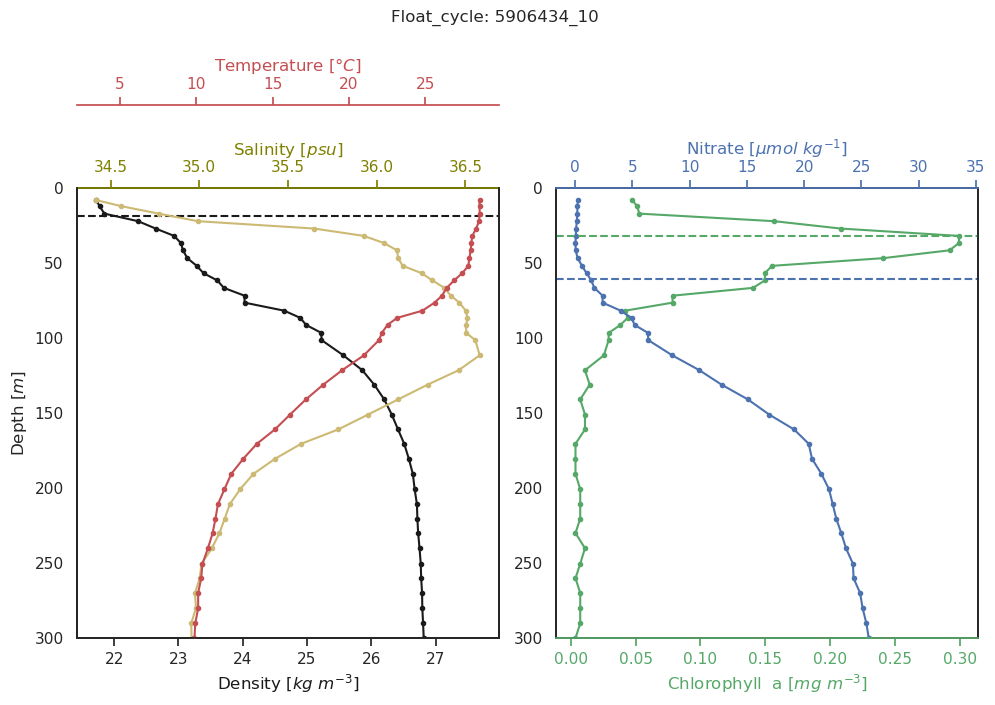

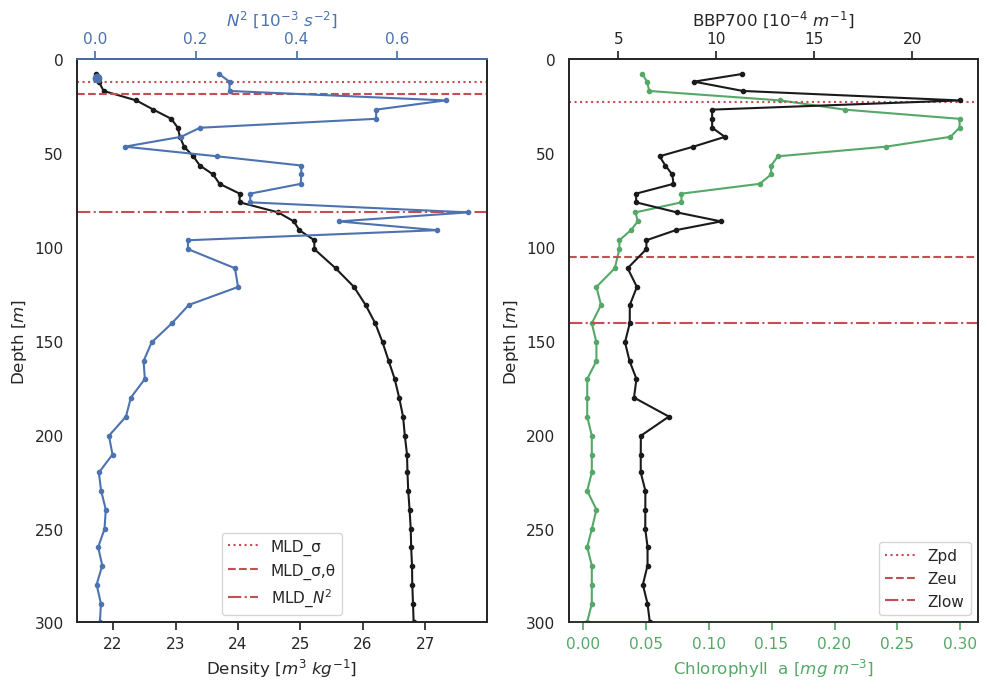

In [23]:
# Single profile analysis example
test = xr.open_dataset(f"Downloads/5906434_Sprof.nc")
test['N_PROF'] = test.N_PROF
def_var(test.isel(N_PROF=9),plot=True,plot_extra=True,verbose=True,zmax=300,flag=[1,2,3,4,5,6,7,8],N2_local_max=0)
'''
Function to calculate habitat defining variable of a single float cycle from BGC-ARGO
Input:
- mydata: input BGC-ARGO data download by argo_download.py
- data_mode: list of data mode to be included in calculation. 'D': delayed mode, 'A': adjusted real time mode, 'R': real time mode
- flag: list of quality control flag to be included in calculation. Remove 3 & 4 by default for 'bad' and 'potentially bad' data.
- var_adj: whether adjusted data should be used
- depth_top: end code if minimum profile depth higher than depth_top
- depth_bottom: end code if maximum profile depth lower than depth_bottom 
- N2_local_max: n-th local maximum from surface, set to FALSE or 0 for global maximum
- d_sigma: density difference to define mixed layer depth
- d_theta: temperature difference to define mixed layer depth
- smooth: set to True to apply smoothing using rolling_average function
- smooth_window: depth interval used in rolling_average function
- by_mean: set to True for using rolling mean, False for rolling median
- peak_height: peak filtering criteria for signal processing
- CHLA_threshold: criteria for defining depth of constant chlorophyll
- dNITRATE_ref: criteria for defining depth of the nitracline
- NAI_boundary: suface boundary for NAI calculation, default is 0.5 uM as in Weber et al. 2019
- plot: option to plot water column profiles, default is FALSE
- plot_extra: option to plot advance profile
- zmax: depth limit for plotting, default is 500m
- verbose: show more information
'''

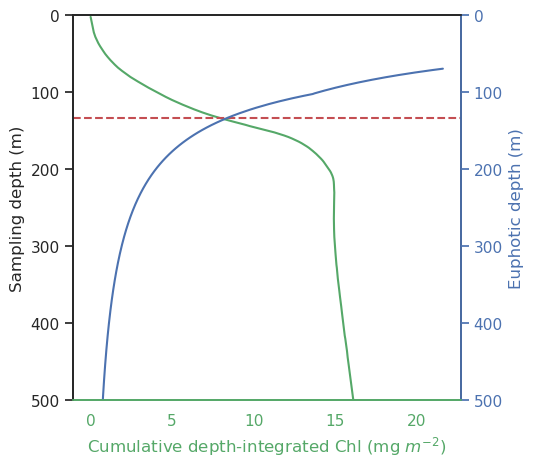

In [20]:
# Morel & Berthon Bio-optical model example
chla = test.isel(N_PROF=12).CHLA_ADJUSTED.values
depth = test.isel(N_PROF=12).PRES_ADJUSTED.values
table = pd.DataFrame({'chla':chla,'depth':depth}).dropna()
table
chl_a = table.chla
depths= table.depth
chl_a += 1e-10
# Integrate Chl-a profile
chl_tot = cumtrapz(chl_a, depths, initial=0)
# Calculate Zeu using vectorized operations
zeu_est_a1 = 912.5 * (chl_tot ** -0.839)
zeu_est_a2 = 426.3 * (chl_tot ** -0.547)
zeu_est = np.where(zeu_est_a1 < 102, zeu_est_a1, zeu_est_a2)
# Find the crossover point
crossover_index = np.where(zeu_est <= depths)[0][0]
# Interpolate to find exact Zeu
zeu_exact = np.interp(depths[crossover_index], [depths[crossover_index], depths[crossover_index+1]], [zeu_est[crossover_index], zeu_est[crossover_index+1]])
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(chl_tot,depths,'g-',label='Integrated Chl')
ax2=ax.twinx()
ax2.plot(chl_tot,zeu_est,'b-',label='Estimated Euphotic depth')
ax.axhline(y=zeu_exact,linestyle='--',color='r')
ax.set_ylim(500,0)
ax2.set_ylim(500,0)
ax.set_xlabel('Cumulative depth-integrated Chl (mg $m^{-2}$)')
ax.set_ylabel('Sampling depth (m)')
ax2.set_ylabel('Euphotic depth (m)')
ax.spines['bottom'].set_color('g')
ax.tick_params(axis='x', colors='g')
ax.xaxis.label.set_color('g')
ax2.spines['right'].set_color('b')
ax2.spines['bottom'].set_color('g')
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')

Text(0.5, 0, '')

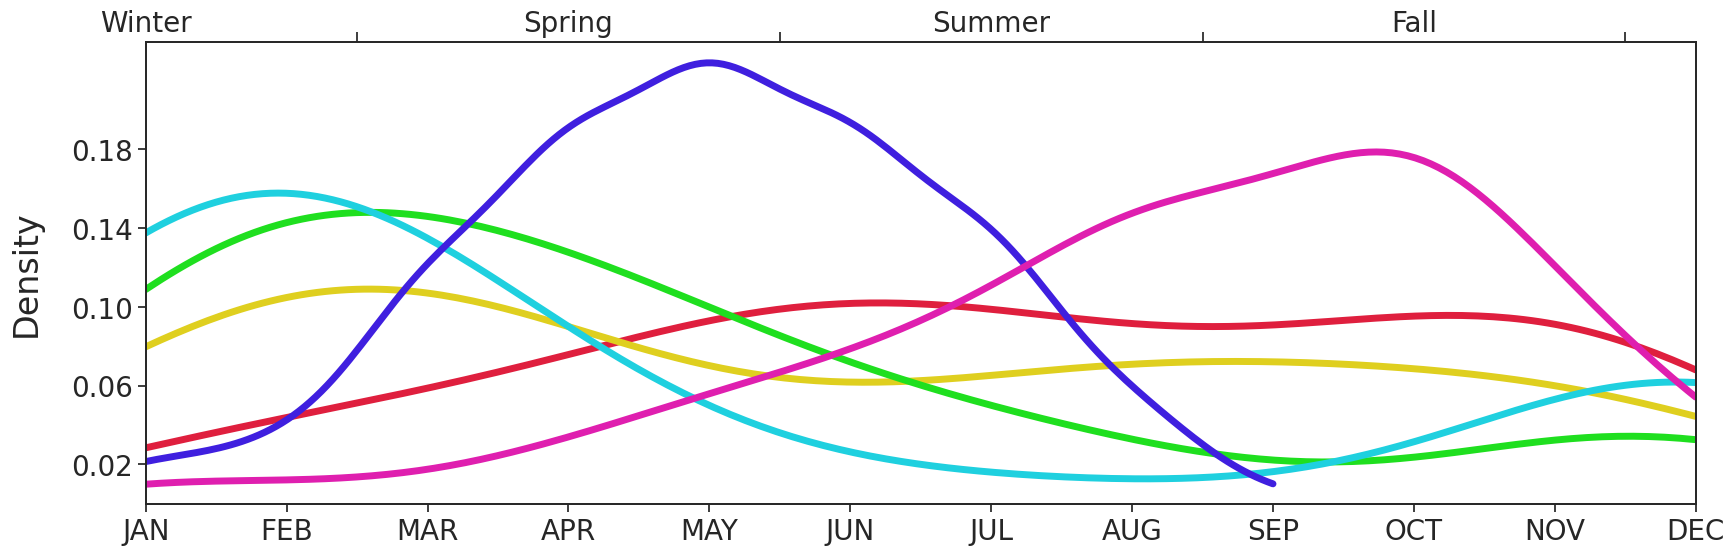

In [24]:
sns.set(font_scale=1)
sns.set_style(style='white')
color_dict = dict(zip(data_clean['Cluster'].cat.categories,mycolor))
df = data_clean#[np.in1d(data_clean.Cluster,[3,4,5,6])]
#df = data_clean[(data_clean.Cluster==2)&(data_clean.Province!='NATR')]
plt.figure(figsize=(20,6))
for i in range(1,k+1):
    sns.kdeplot(df[df.Cluster==i],x='Month',linewidth=5,cut=0,color=color_dict[i],label=f'Cluster {i}')
#plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tick_params(left=True,bottom=True,labelsize=20)
ax = plt.gca()
ax.spines[:].set_visible(True)
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"])
ax2 = ax.twiny()
ax.set_xlim(1,12)
ax.set_yticks(np.arange(0.02,0.2,0.04))
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([2.5,5.5,8.5,11.5])
ax2.set_xticks([1,4,7,10],minor=True)
ax2.set_xticklabels([])
ax2.set_xticklabels(['Winter','Spring','Summer','Fall'],minor=True,size=20)
ax2.tick_params(which='major', length=7)
ax2.tick_params(which='minor', length=0)
#ax.set_xlabel('Month',size=24,labelpad=20)
ax.set_ylabel('Density',size=24,labelpad=20)
ax.set_xlabel('',size=24,labelpad=20)

Cluster  CHL_profile
1        DAM            0.48
         DBM            0.43
         NO             0.09
2        DBM            0.51
         DAM            0.40
         NO             0.09
3        DAM            0.61
         DBM            0.38
         NO             0.01
4        DAM            0.83
         DBM            0.14
         NO             0.04
5        DAM            0.80
         DBM            0.20
6        DAM            0.87
         DBM            0.13
         NO             0.00
Name: CHL_profile, dtype: float64

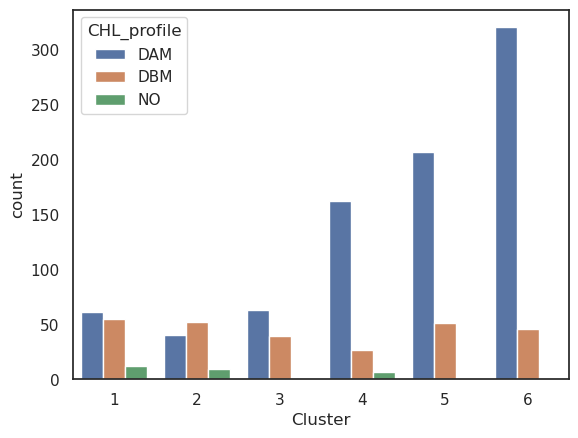

In [26]:
### Chlorophyll profile
sns.countplot(data_clean,x='Cluster',hue='CHL_profile')
data_clean.groupby('Cluster').CHL_profile.value_counts(normalize=True).round(2)

## Phytoplankton functional types

In [ ]:
# # PFT matching
# # In terminal, run config_opendap_MAC/WIN first

# # # Open pft data
# pft=xr.open_dataset("https://my.cmems-du.eu/thredds/dodsC/cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D")

# # List of variable to mine
# pft_list = ['CHL','DIATO','DINO','HAPTO','GREEN','PROKAR','PROCHLO','MICRO','NANO','PICO']
# for i in pft_list:
#     data_clean[i] = np.nan

# # Create wraper function for parallelization
# def wraper_func2(files):
#     outfile = PFT_matchup(files,pft=pft,pft_list=pft_list,time_bound=36,grid_size=3)
#     return(outfile)

# # Run
# data_pft = parallelize_pft(wraper_func2,data_clean)

# # Export
# data_pft.to_csv("data_pft.csv",index=False)

In [27]:
data_pft = pd.read_csv('data_pft.csv')
# data_pft['CHL_mean_Zeu'] = data_pft.CHL_Zeu/data_pft.Zeu
# data_pft['CHL_mean_Zpd'] = data_pft.CHL_Zpd/data_pft.Zpd
# data_pft['CHL_mean_Zlow'] = data_pft.CHL_Zlow/data_pft.Zlow
# data_pft['Cluster'] = cluster
# data_pft.to_csv("data_pft.csv",index=False)

In [28]:
# Data cleaning
pft_list = ['CHL','DIATO','DINO','HAPTO','GREEN','PROKAR','PROCHLO','MICRO','NANO','PICO']
pft_clean = filter_outliers_1(data_pft, 'Cluster',pft_list,lower_quantile=0,upper_quantile=0.75)
pft_clean.to_csv("data_pft_clean.csv",index=False)

## Full map

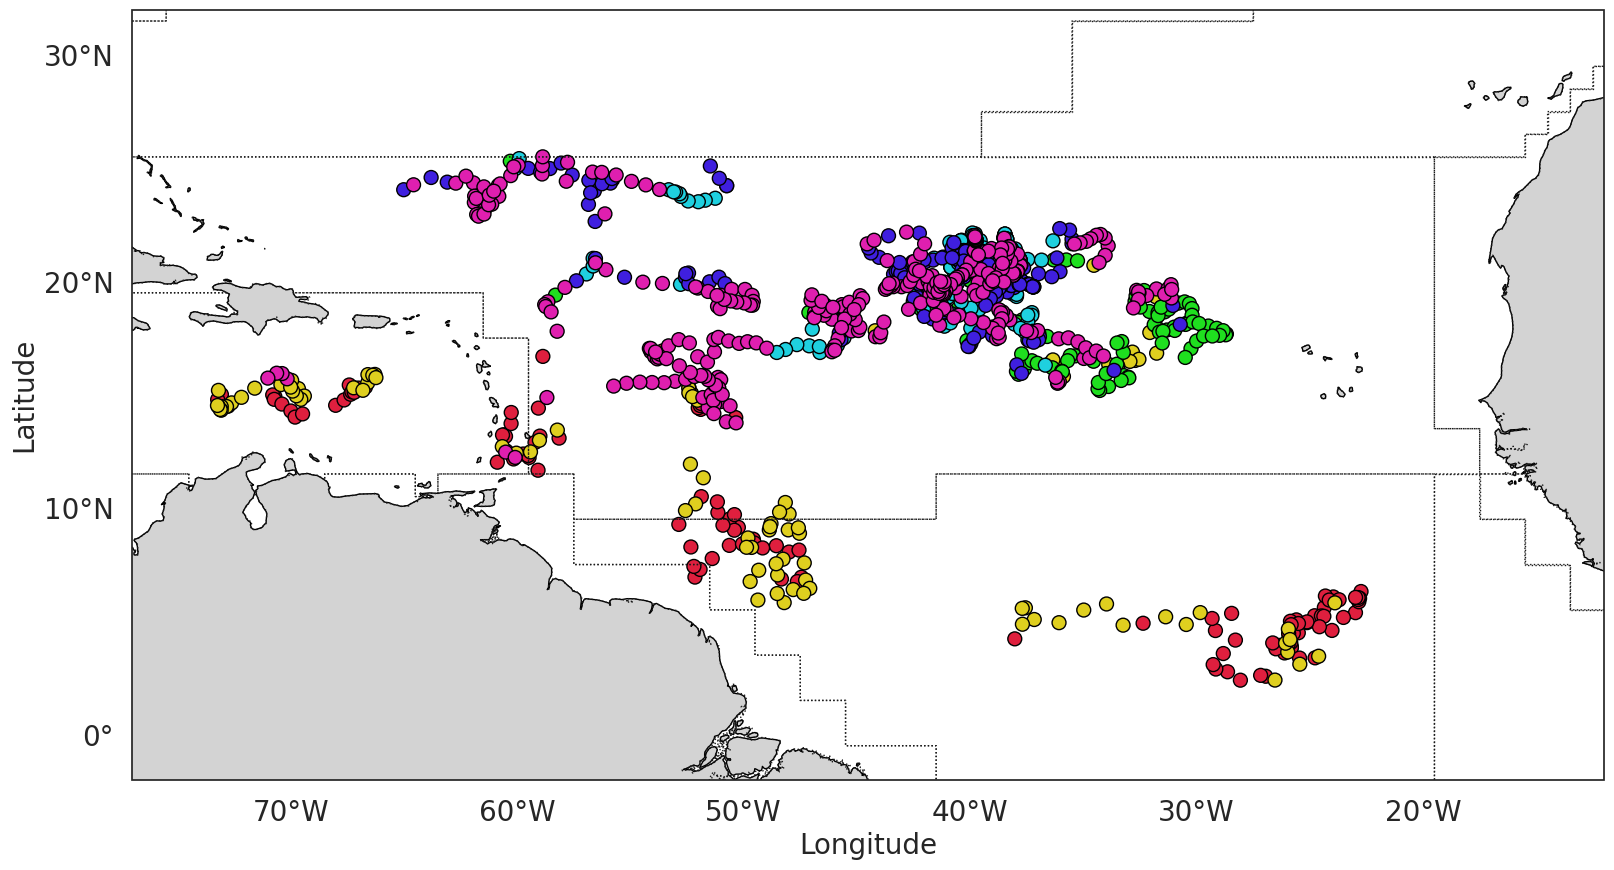

In [32]:
import cartopy.crs as ccrs
import geopandas as gp
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.patches as mpatches
# Set region file
df  = pd.read_csv('data_pft.csv').sort_values(by='Cluster')
file = gp.read_file('longhurst_v4_2010/')
df['Cluster'] = df.Cluster.astype('category')
colormap = dict(zip(df.Cluster.cat.categories,mycolor))
lhprovinces = regionmask.from_geopandas(file, names="ProvDescr", abbrevs="ProvCode", name="Biogeochemical Provinces")
#mask = lhprovinces.mask(np.arange(-80,-10), np.arange(-5,35),wrap_lon=False)

# Plot regions
f, ax = plt.subplots(figsize=(20,10),subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
ax.add_feature(cfeature.LAND,facecolor='lightgray')
lhprovinces.plot(add_label=False,add_coastlines=False,line_kws=dict(lw=1,linestyle="dotted"))
# Add float profiles
ax.scatter(df.Lon, df.Lat,
           transform=ccrs.PlateCarree(),c=df.Cluster.map(colormap),
           s=100,alpha=1,edgecolor='black')

# Edit axes
ax.set_xticks(np.arange(-70, 0, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-10, 40, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.tick_params(axis='both', direction='out', which='major', labelsize=20,length=10)
ax.set_xlabel('Longitude',size=20)
ax.set_ylabel('Latitude',size=20)
# cir=gp.read_file('surface_circulation.geojson')
# ax.add_geometries(cir[cir.TEMP=='cold'].geometry, crs=ccrs.PlateCarree(),alpha=1,edgecolor='blue',facecolor='none', linestyle='--')
# ax.add_geometries(cir[cir.TEMP=='warm'].geometry, crs=ccrs.PlateCarree(),alpha=1,edgecolor='red',facecolor='none', linestyle='--')
plt.xlim(-77,-12)
plt.ylim(-2,32)
plt.show()